In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-04-21'
end_day_to_analyze = '2020-04-22'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2329,413,APDN,buy,231,6.56,"{'avg': 6.4119, 'rsi': 69.87703728105052, 'mac...",2020-04-21 14:12:34.598964+00:00,2020-04-21 14:12:34.755285,6.16,7.80
1,2348,413,APDN,sell,115,6.88,"{'avg': 6.4992, 'rsi': 69.4659719198261, 'vwap...",2020-04-21 14:32:04.721680+00:00,2020-04-21 14:32:04.832711,6.16,7.80
2,2361,413,APDN,sell,116,6.53,"{'avg': 6.534, 'rsi': 42.12743250142867, 'vwap...",2020-04-21 14:44:05.504259+00:00,2020-04-21 14:44:05.693561,6.16,7.80
3,2310,413,BNTC,buy,50,14.25,"{'avg': 13.3825, 'rsi': 62.853742479598075, 'm...",2020-04-21 13:47:27.633574+00:00,2020-04-21 13:47:27.850040,12.39,19.83
4,2311,413,BNTC,sell,25,15.00,"{'avg': 13.4849, 'rsi': 66.6075405500883, 'vwa...",2020-04-21 13:47:52.263157+00:00,2020-04-21 13:47:52.387663,12.39,19.83
...,...,...,...,...,...,...,...,...,...,...,...
78,2343,413,UNIT,sell,761,5.34,"{'avg': 5.1742, 'rsi': 79.15069730038424, 'vwa...",2020-04-21 14:22:55.497997+00:00,2020-04-21 14:22:55.697064,5.17,5.67
79,2347,413,UNIT,buy,373,5.42,"{'avg': 5.2218, 'rsi': 70.35397894329463, 'mac...",2020-04-21 14:29:01.409485+00:00,2020-04-21 14:29:01.550585,5.17,6.18
80,2357,413,UNIT,sell,373,5.51,"{'avg': 5.2674, 'rsi': 80.1507177995056, 'vwap...",2020-04-21 14:39:39.307223+00:00,2020-04-21 14:39:39.446425,5.17,6.18
81,2327,413,VXRT,buy,316,3.33,"{'avg': 3.09, 'rsi': 63.995265511304154, 'macd...",2020-04-21 14:07:57.780502+00:00,2020-04-21 14:07:57.924038,3.04,4.24


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,413,momentum_long,PAPER,v0.1-306-gea7ed65,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-21 13:45:01.777386,None,None


,symbol,count,revenue
12,VXRT,2,-60.04
15,PAVM,2,-54.32
2,LIFE,8,-9.94
5,LABD,5,-9.80
13,FNGD,2,5.94
3,TSC,7,7.76
14,SQQQ,2,16.94
8,INO,3,17.07
1,BNTC,10,21.61
11,APDN,3,33.32


TOTAL REVENUE: 320.65 $


In [11]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [18]:
minute_history['LIFE']['close'].between_time("9:30", "16:00").max()

3.74

In [12]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-21 10:36:43.802090
now=2020-04-21 10:52:35.300881
now=2020-04-21 10:53:06.277344
now=2020-04-21 10:53:33.760445
now=2020-04-21 10:53:34.029172
now=2020-04-21 10:53:37.941285
now=2020-04-21 10:53:52.158162
now=2020-04-21 10:54:27.399392
now=2020-04-21 11:00:13.639963
SOXS analysis for run 413 with profit 38.19


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4632.20,-4632.20,buy,2020-04-21 14:36:43.802090,12.19,[11.9699],"[12.36, 12.36, 12.43, 12.44, 12.44, 12.45]",380,"{'avg': 11.8753, 'rsi': 70.8664309641996, 'macd': [0.04038477452133904, 0.04462713799721918, 0.04744235567208577, 0.05070279851510584, 0.055878327255191707], 'vwap': 12.1882, 'sell_macd': [0.021397017372443372, 0.02428046839261455, 0.026211982585053306, 0.028415604259874883, 0.03184679511999633], 'slow macd': [0.09544246601661222, 0.0953413898579587, 0.09509591132917272, 0.09503784266061821, 0.09547376134235286], 'macd_signal': [0.04491873767000753, 0.04486041773544986, 0.04537680532277704, 0.0464420039612428, 0.04832926862003258], 'resistances': [12.36, 12.36, 12.43], 'sell_macd_signal': [0.023849274167580106, 0.023935513012586996, 0.024390806927080257, 0.02519576639363918, 0.02652597213891061]}",12.94,11.94
1,49.40,4681.60,sell,2020-04-21 14:40:30.104880,12.32,None,None,380,"{'avg': 11.8988, 'rsi': 78.15627777797867, 'vwap': 12.325, 'reasons': 'rsi max', 'movement': 0.011066357125864434, 'sell_macd': [0.03340004187324297, 0.03775934336582587, 0.04009439201763243, 0.04468671055127871, 0.049508170310597066], 'sell_macd_signal': [0.02683662148955994, 0.029021165864813125, 0.031235811095376986, 0.03392599098655733, 0.03704242685136528]}",12.94,11.94
2,-1895.85,-1945.25,buy,2020-04-21 14:52:35.300881,12.55,[11.9699],[12.55],155,"{'avg': 11.9966, 'rsi': 77.66560936791423, 'macd': [0.09461262934272519, 0.10786009354168868, 0.11772793479681276, 0.12260185105314214, 0.12503125152686678], 'vwap': 12.5501, 'sell_macd': [0.05614374156695412, 0.06463737395505476, 0.07088387485545766, 0.07384369536414148, 0.07519623478176385], 'slow macd': [0.10640369148576845, 0.10974506759636071, 0.11278766102302562, 0.11510267774860061, 0.1170500758991615], 'macd_signal': [0.085297804197148, 0.08981026206605613, 0.09539379661220745, 0.1008354075003944, 0.10567457630568887], 'resistances': [12.81, 12.81], 'sell_macd_signal': [0.05044134576005761, 0.05328055139905704, 0.05680121609033716, 0.06020971194509803, 0.06320701651243119]}",14.38,11.94
3,46.30,1942.15,sell,2020-04-21 14:52:38.888919,12.53,None,None,155,"{'avg': 11.9987, 'rsi': 78.53280943596606, 'vwap': 12.571, 'reasons': 'rsi max', 'movement': 0.0015856447358985034, 'sell_macd': [0.05614374156695412, 0.06463737395505476, 0.07088387485545766, 0.07384369536414148, 0.0762300010155279], 'sell_macd_signal': [0.05044134576005761, 0.05328055139905704, 0.05680121609033716, 0.06020971194509803, 0.063413769759184]}",14.38,11.94
4,-1872.32,-1918.62,buy,2020-04-21 14:53:06.277344,12.54,[11.9699],[12.55],153,"{'avg': 12.001, 'rsi': 78.10561572011629, 'macd': [0.09461262934272519, 0.10786009354168868, 0.11772793479681276, 0.12260185105314214, 0.12582099511661227], 'vwap': 12.5595, 'sell_macd': [0.05614374156695412, 0.06463737395505476, 0.07088387485545766, 0.07384369536414148, 0.07571052049604887], 'slow macd': [0.10640369148576845, 0.10974506759636071, 0.11278766102302562, 0.11510267774860061, 0.11720841256449432], 'macd_signal': [0.085297804197148, 0.08981026206605613, 0.09539379661220745, 0.1008354075003944, 0.10583252502363796], 'resistances': [12.81, 12.81], 'sell_macd_signal': [0.05044134576005761, 0.05328055139905704, 0.05680121609033716, 0.06020971194509803, 0.0633098736552882]}",14.42,11.94
5,44.77,1917.09,sell,2020-04-21 14:53:09.650005,12.53,None,None,153,"{'avg': 12.0018, 'rsi': 78.01373584840987, 'vwap': 12.5552, 'reasons': 'rsi max', 'movement': -0.00016719745222933398, 'sell_macd': [0.05614374156695412, 0.06463737395505476, 0.07088387485545766, 0.07384369536414148, 0.0756014295869587], 'sell_macd_signal': [0.05044134576005761, 0.05328055139905704, 0.05680121609033716, 0.06020971194509803, 0.06328805547347016]}",14.42,11.94
6,-1751.31,-1796.08,buy,2020-04-21 14:53:33.760445,12.56,[11.9699],"[12.81, 12.81, 12.8597, 12.86]",143,"{'avg': 12.0058, 'rsi': 78.13841120742362, 'macd': [0.10786009354

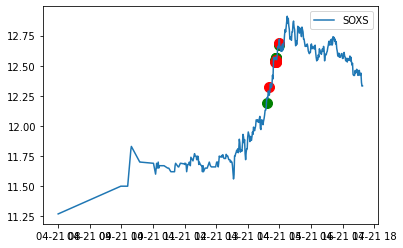

now=2020-04-21 09:47:27.850040
now=2020-04-21 09:55:06.857086
BNTC analysis for run 413 with profit 21.61


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-712.50,-712.50,buy,2020-04-21 13:47:27.850040,14.25,"[9.25, 12.25, 12.4, 12.57, 12.57]","[14.5064, 15.0]",50,"{'avg': 13.3825, 'rsi': 62.853742479598075, 'macd': [0.14844930958231473, 0.15811479841559617, 0.16423659395830192, 0.19083758369736437, 0.2374242556160322], 'vwap': 14.2078, 'sell_macd': [0.09082617650370928, 0.09670238726797287, 0.10025394906781493, 0.11713758230057714, 0.1469542110235018], 'slow macd': [0.05541350985771665, 0.0614688801348624, 0.06701207545160592, 0.07675171724369534, 0.0911875064858485], 'macd_signal': [0.13132252202370753, 0.13668097730208525, 0.1421921006333286, 0.15192119724613576, 0.16902180892011504], 'resistances': [14.5064, 15.0], 'sell_macd_signal': [0.08116010275074223, 0.08426855965418836, 0.08746563753691368, 0.09340002648964638, 0.10411086339641747]}",19.83,12.39
1,-337.50,375.00,sell,2020-04-21 13:47:52.387663,15.00,None,None,25,"{'avg': 13.4849, 'rsi': 66.6075405500883, 'vwap': 14.5849, 'reasons': 'scale-out', 'movement': 0.034385964912280714, 'sell_macd': [0.09082617650370928, 0.09670238726797287, 0.10025394906781493, 0.11713758230057714, 0.1724087564780472], 'sell_macd_signal': [0.08116010275074223, 0.08426855965418836, 0.08746563753691368, 0.09340002648964638, 0.10920177248732654]}",19.83,12.39
2,-153.78,183.72,sell,2020-04-21 13:47:59.704097,15.31,None,None,12,"{'avg': 13.5566, 'rsi': 69.0933948607641, 'vwap': 15.0186, 'reasons': 'scale-out', 'movement': 0.026458616010854856, 'sell_macd': [0.09082617650370928, 0.09670238726797287, 0.10025394906781493, 0.11713758230057714, 0.1926684967377863], 'sell_macd_signal': [0.08116010275074223, 0.08426855965418836, 0.08746563753691368, 0.09340002648964638, 0.11325372053927436]}",19.83,12.39
3,-122.82,30.96,sell,2020-04-21 13:48:21.457418,15.48,None,None,2,"{'avg': 13.8129, 'rsi': 71.17569466362758, 'vwap': 15.48, 'reasons': 'scale-out', 'movement': 0.023132848645075983, 'sell_macd': [0.09670238726797287, 0.10025394906781493, 0.11713758230057714, 0.19162953569882646, 0.26640729762345217], 'sell_macd_signal': [0.08426855965418836, 0.08746563753691368, 0.09340002648964638, 0.11304592833148239, 0.14371820218987635]}",19.83,12.39
4,-60.90,61.92,sell,2020-04-21 13:48:21.549643,15.48,None,None,4,"{'avg': 13.8129, 'rsi': 71.17569466362758, 'vwap': 15.48, 'reasons': 'scale-out', 'movement': 0.023132848645075983, 'sell_macd': [0.09670238726797287, 0.10025394906781493, 0.11713758230057714, 0.19162953569882646, 0.26640729762345217], 'sell_macd_signal': [0.08426855965418836, 0.08746563753691368, 0.09340002648964638, 0.11304592833148239, 0.14371820218987635]}",19.83,12.39
5,-12.75,48.15,sell,2020-04-21 13:53:36.191396,16.05,None,None,3,"{'avg': 13.9536, 'rsi': 72.96203247500557, 'vwap': 15.9311, 'reasons': 'scale-out', 'movement': 0.020671834625323016, 'sell_macd': [0.10025394906781493, 0.11713758230057714, 0.19162953569882646, 0.26640729762345217, 0.3378392251280502], 'sell_macd_signal': [0.08746563753691368, 0.09340002648964638, 0.11304592833148239, 0.14371820218987635, 0.18254240677751113]}",19.83,12.39
6,20.81,33.56,sell,2020-04-21 13:53:42.543984,16.78,None,None,2,"{'avg': 14.1043, 'rsi': 75.7346693122486, 'vwap': 16.2669, 'reasons': 'scale-out', 'movement': 0.037341772151898725, 'sell_macd': [0.10025394906781493, 0.11713758230057714, 0.19162953569882646, 0.26640729762345217, 0.3684885757774019], 'sell_macd_signal': [0.08746563753691368, 0.09340002648964638, 0.11304592833148239, 0.14371820218987635, 0.18867227690738148]}",19.83,12.39
7,54.37,33.56,sell,2020-04-21 13:53:43.465056,16.78,None,None,2,"{'avg': 14.1891, 'rsi': 79.08517764846746, 'vwap': 16.7139, 'reasons': 'rsi max', 'movement': 0.05623550945698583, 'sell_macd': [0.10025394906781493, 0.11713758230057714, 0.19162953569882646, 0.26640729762345217, 0.4163690952579202], 'sell_macd_signal': [0.08746563753691368, 0.09340002648964638, 0.11304592833148239, 0.14371820218987635, 0.1982483808034851]}",19.83,

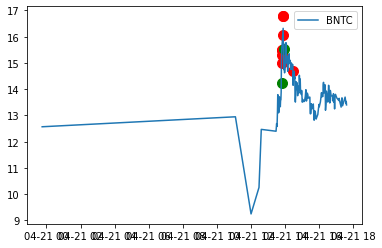

now=2020-04-21 10:19:54.690486
now=2020-04-21 10:36:48.772176
now=2020-04-21 10:37:46.129933
now=2020-04-21 10:39:22.208892
LIFE analysis for run 413 with profit -9.94


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-897.50,-897.50,buy,2020-04-21 14:19:54.690486,3.59,[3.28],"[3.72, 4.13]",250,"{'avg': 3.6021, 'rsi': 71.8018458333335, 'macd': [0.03411558323103758, 0.03622736073079036, 0.03636818514534568, 0.03761962096705895, 0.05119815762547164], 'vwap': 3.6083, 'sell_macd': [0.020602556127566007, 0.021944961761321657, 0.021989109505009985, 0.022750924506520498, 0.031532196916703725], 'slow macd': [0.03542127103101267, 0.03615342965713042, 0.0365485049390446, 0.037165407859447885, 0.04028529270087544], 'macd_signal': [0.0185666763929157, 0.02209881326049063, 0.02495268763746164, 0.027486074303381104, 0.032228490967799214], 'resistances': [3.72, 3.99, 4.33], 'sell_macd_signal': [0.010157361069892947, 0.01251488120817869, 0.014409726867544949, 0.01607796639534006, 0.019168812499612792]}",4.78,3.26
1,25.00,922.50,sell,2020-04-21 14:36:47.000305,3.69,None,None,250,"{'avg': 3.6057, 'rsi': 78.38664904901823, 'vwap': 3.747, 'reasons': 'rsi max', 'movement': 0.013876936316695378, 'sell_macd': [0.037678214884647954, 0.0380285237357465, 0.03832190045432027, 0.03909177970964617, 0.04437880536691807], 'sell_macd_signal': [0.031088649189366706, 0.032476624098642666, 0.033645679369778185, 0.03473489943775178, 0.036663680623585035]}",4.78,3.26
2,-683.48,-708.48,buy,2020-04-21 14:36:48.772176,3.69,[3.28],"[3.72, 4.13]",192,"{'avg': 3.6057, 'rsi': 77.55588004551417, 'macd': [0.062339985179422186, 0.06307623621561653, 0.0637239971560466, 0.06510074436400703, 0.07221813041737768], 'vwap': 3.7603, 'sell_macd': [0.037678214884647954, 0.0380285237357465, 0.03832190045432027, 0.03909177970964617, 0.043599584587697304], 'slow macd': [0.05005385218386227, 0.05118550480315953, 0.052303134014590746, 0.05356760913632019, 0.056004749007793286], 'macd_signal': [0.051669341635216366, 0.0539507205512964, 0.055905375872246435, 0.05774444957059856, 0.06063918573995438], 'resistances': [4.33], 'sell_macd_signal': [0.031088649189366706, 0.032476624098642666, 0.033645679369778185, 0.03473489943775178, 0.03650783646774088]}",5.24,3.26
3,34.60,718.08,sell,2020-04-21 14:37:14.067097,3.74,None,None,192,"{'avg': 3.6079, 'rsi': 78.3455444552348, 'vwap': 3.7576, 'reasons': 'rsi max', 'movement': 0.0026631158455393427, 'sell_macd': [0.0380285237357465, 0.03832190045432027, 0.03909177970964617, 0.041261922250034555, 0.045274216148389], 'sell_macd_signal': [0.032476624098642666, 0.033645679369778185, 0.03473489943775178, 0.036040304000208336, 0.037887086429844466]}",5.24,3.26
4,-679.64,-714.24,buy,2020-04-21 14:37:46.129933,3.72,[3.28],"[3.72, 4.13]",192,"{'avg': 3.608, 'rsi': 77.75321469335384, 'macd': [0.06307623621561653, 0.0637239971560466, 0.06510074436400703, 0.06862838682763428, 0.07419986298201309], 'vwap': 3.7558, 'sell_macd': [0.0380285237357465, 0.03832190045432027, 0.03909177970964617, 0.041261922250034555, 0.04475473562890819], 'slow macd': [0.05118550480315953, 0.052303134014590746, 0.05356760913632019, 0.055285036892639194, 0.05749641678856854], 'macd_signal': [0.0539507205512964, 0.055905375872246435, 0.05774444957059856, 0.059921237022005705, 0.06277696221400718], 'resistances': [4.33], 'sell_macd_signal': [0.032476624098642666, 0.033645679369778185, 0.03473489943775178, 0.036040304000208336, 0.037783190325948304]}",5.24,3.26
5,30.76,710.40,sell,2020-04-21 14:37:49.949520,3.70,None,None,192,"{'avg': 3.6106, 'rsi': 78.0533755268005, 'vwap': 3.76, 'reasons': 'rsi max', 'movement': 0.0013315579227696122, 'sell_macd': [0.0380285237357465, 0.03832190045432027, 0.03909177970964617, 0.041261922250034555, 0.0450144758886486], 'sell_macd_signal': [0.032476624098642666, 0.033645679369778185, 0.03473489943775178, 0.036040304000208336, 0.037835138377896385]}",5.24,3.26
6,-666.69,-697.45,buy,2020-04-21 14:39:22.208892,3.77,[3.28],[4.13],185,"{'avg': 3.6135, 'rsi': 75.8581633871893, 'macd': [0.06510074436400703, 0.06862838682763428, 0.0685360453181949, 0.072149896895493, 0.07675163363673221

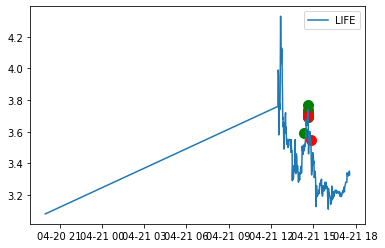

now=2020-04-21 10:10:30.868635
now=2020-04-21 10:41:55.322963
TSC analysis for run 413 with profit 7.76


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1456.00,-1456.00,buy,2020-04-21 14:10:30.868635,13.00,"[10.22, 10.27, 12.285]",[13.3374],112,"{'avg': 11.9722, 'rsi': 67.8013050143865, 'macd': [0.35540766489235054, 0.400115693036609, 0.4044662484996415, 0.41124270934959917, 0.4124796207351835], 'vwap': 13.1177, 'sell_macd': [0.20380952316980583, 0.23277413870174435, 0.2353131360162184, 0.23943036592339162, 0.23992911174815745], 'slow macd': [0.3263673916897183, 0.3406236004929717, 0.34795868328158264, 0.3557500430430647, 0.3624725215072768], 'macd_signal': [0.37308048185182885, 0.3784875240887849, 0.3836832689709562, 0.38919515704668484, 0.3938520497843846], 'resistances': [13.3374], 'sell_macd_signal': [0.2171780236487127, 0.22029724665931902, 0.2233004245306989, 0.22652641280923744, 0.22920695259702145]}",15.65,12.28
1,-696.64,759.36,sell,2020-04-21 14:15:44.659172,13.56,None,None,56,"{'avg': 12.064, 'rsi': 69.40449728358799, 'vwap': 13.3785, 'reasons': 'scale-out', 'movement': 0.023807527234195054, 'sell_macd': [0.22150456529948315, 0.22152972027992845, 0.21644374078053552, 0.21528526661502845, 0.2230152183482037], 'sell_macd_signal': [0.22577390370894235, 0.22492506702313958, 0.22322880177461876, 0.2216400947427007, 0.2219151194638013]}",15.65,12.28
2,-313.32,383.32,sell,2020-04-21 14:16:03.329945,13.69,None,None,28,"{'avg': 12.1516, 'rsi': 72.5886500323498, 'vwap': 13.6358, 'reasons': 'scale-out', 'movement': 0.020089352196574838, 'sell_macd': [0.22150456529948315, 0.22152972027992845, 0.21644374078053552, 0.21528526661502845, 0.23703080276378863], 'sell_macd_signal': [0.22577390370894235, 0.22492506702313958, 0.22322880177461876, 0.2216400947427007, 0.2247182363469183]}",15.65,12.28
3,-116.06,197.26,sell,2020-04-21 14:16:32.921693,14.09,None,None,14,"{'avg': 12.295, 'rsi': 76.26404048283027, 'vwap': 13.9871, 'reasons': 'scale-out', 'movement': 0.02702229229623794, 'sell_macd': [0.22152972027992845, 0.21644374078053552, 0.21528526661502845, 0.2351762573092433, 0.2687072077552646], 'sell_macd_signal': [0.22492506702313958, 0.22322880177461876, 0.2216400947427007, 0.2243473272560092, 0.23321930335586027]}",15.65,12.28
4,64.96,181.02,sell,2020-04-21 14:34:09.656331,12.93,None,None,14,"{'avg': 13.21, 'rsi': 43.4843259607202, 'vwap': 12.9171, 'reasons': 'below cost & macd negative', 'movement': -0.08201137171286425, 'sell_macd': [0.05911486792042098, 0.047217702359960256, 0.035256044749729654, 0.015607272004748651, -0.0032256323680250887], 'sell_macd_signal': [0.1397590504414461, 0.12125078082514892, 0.10405183361006506, 0.08636292128900178, 0.0684452105575964]}",15.65,12.28
5,-1360.88,-1425.84,buy,2020-04-21 14:41:55.322963,13.71,"[12.89, 12.98]",[14.106],104,"{'avg': 13.2079, 'rsi': 64.85393918339547, 'macd': [0.009290580663426695, 0.0036073276536310317, 0.031022359310872716, 0.0625102347196993, 0.0970536102141395], 'vwap': 13.7666, 'sell_macd': [-0.014813138572423057, -0.01717255592316924, 0.001991178036290009, 0.023646150237995656, 0.047106568184284825], 'slow macd': [0.3226148903145809, 0.31410906489613666, 0.3121785009027658, 0.31198060336083877, 0.313421912974027], 'macd_signal': [0.0875375606129799, 0.07075151402111013, 0.06280568307906265, 0.06274659340718998, 0.06960799676857989], 'resistances': [14.106], 'sell_macd_signal': [0.03179755682159485, 0.022003534272642032, 0.018001063025371626, 0.01913008046789643, 0.02472537801117411]}",16.50,12.85
6,7.76,1368.64,sell,2020-04-21 14:55:01.667853,13.16,None,None,104,"{'avg': 13.2403, 'rsi': 48.20643629645748, 'vwap': 13.2183, 'reasons': 'below cost & macd negative', 'movement': -0.041605510586662495, 'sell_macd': [0.004852125961321008, 0.003490219601157918, 0.002778471533485316, 0.0037462201621352165, -0.00022366688258124157], 'sell_macd_signal': [0.014199064906448103, 0.012057295845390066, 0.010201530983009115, 0.008910468818834335, 0.0070836416785512194]}",16.50,12.85


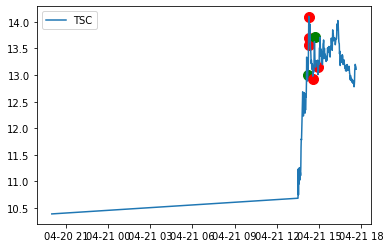

now=2020-04-21 10:14:16.114285
CLDX analysis for run 413 with profit 70.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2200.00,-2200.00,buy,2020-04-21 14:14:16.114285,2.20,"[2.0701, 2.085, 2.0894, 2.0944, 2.1001, 2.11, 2.11, 2.14, 2.14, 2.1412]",[2.25],1000,"{'avg': 2.1559, 'rsi': 63.59386722168996, 'macd': [0.010636460662933445, 0.011710619851060589, 0.013216464002999917, 0.013527692737391295, 0.015531901087841415], 'vwap': 2.1997, 'sell_macd': [0.006288947909317777, 0.006966206206560521, 0.007922950253677286, 0.0080980371702144, 0.009376052466603557], 'slow macd': [0.00530709154999931, 0.0057932893362036, 0.006391277320494382, 0.006787281016045199, 0.0075246082369160305], 'macd_signal': [0.011787138961284124, 0.011771835139239416, 0.012060760911991517, 0.012354147277071473, 0.01298969803922546], 'resistances': [2.25], 'sell_macd_signal': [0.007206797316717053, 0.0071586790946857465, 0.0073115333264840545, 0.007468834095230124, 0.00785027776950481]}",2.49,2.11
1,-2177.50,22.50,sell,2020-04-21 14:20:19.943583,2.25,None,None,10,"{'avg': 2.1715, 'rsi': 70.91592590709624, 'vwap': 2.25, 'reasons': 'scale-out', 'movement': 0.02040816326530609, 'sell_macd': [0.013059059685189833, 0.014631320497229261, 0.01535475333132208, 0.01603074315878006, 0.016868777528762813], 'sell_macd_signal': [0.009335597460005406, 0.010394742067450178, 0.011386744320224558, 0.012315544087935658, 0.013226190776101088]}",2.49,2.11
2,-1581.25,596.25,sell,2020-04-21 14:20:20.021423,2.25,None,None,265,"{'avg': 2.1715, 'rsi': 70.91592590709624, 'vwap': 2.25, 'reasons': 'scale-out', 'movement': 0.02040816326530609, 'sell_macd': [0.013059059685189833, 0.014631320497229261, 0.01535475333132208, 0.01603074315878006, 0.016868777528762813], 'sell_macd_signal': [0.009335597460005406, 0.010394742067450178, 0.011386744320224558, 0.012315544087935658, 0.013226190776101088]}",2.49,2.11
3,-1075.00,506.25,sell,2020-04-21 14:20:20.052929,2.25,None,None,225,"{'avg': 2.1715, 'rsi': 70.91592590709624, 'vwap': 2.25, 'reasons': 'scale-out', 'movement': 0.02040816326530609, 'sell_macd': [0.013059059685189833, 0.014631320497229261, 0.01535475333132208, 0.01603074315878006, 0.016868777528762813], 'sell_macd_signal': [0.009335597460005406, 0.010394742067450178, 0.011386744320224558, 0.012315544087935658, 0.013226190776101088]}",2.49,2.11
4,-369.68,705.32,sell,2020-04-21 14:21:34.779746,2.29,None,None,308,"{'avg': 2.1863, 'rsi': 78.10986529408068, 'vwap': 2.2944, 'reasons': 'rsi max', 'movement': 0.022222222222222143, 'sell_macd': [0.014631320497229261, 0.01535475333132208, 0.01603074315878006, 0.017907738567723985, 0.02069620591796939], 'sell_macd_signal': [0.010394742067450178, 0.011386744320224558, 0.012315544087935658, 0.013433982983893323, 0.014886427570708537]}",2.49,2.11
5,70.00,439.68,sell,2020-04-21 14:21:34.856696,2.29,None,None,192,"{'avg': 2.1863, 'rsi': 78.10986529408068, 'vwap': 2.2944, 'reasons': 'rsi max', 'movement': 0.022222222222222143, 'sell_macd': [0.014631320497229261, 0.01535475333132208, 0.01603074315878006, 0.017907738567723985, 0.02069620591796939], 'sell_macd_signal': [0.010394742067450178, 0.011386744320224558, 0.012315544087935658, 0.013433982983893323, 0.014886427570708537]}",2.49,2.11


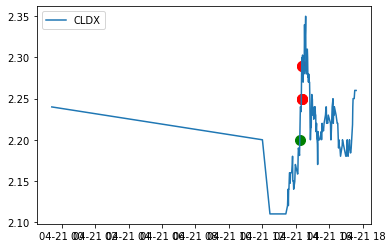

now=2020-04-21 10:57:37.329915
now=2020-04-21 10:57:37.577066
now=2020-04-21 10:58:08.452425
LABD analysis for run 413 with profit -9.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2202.10,-2202.10,buy,2020-04-21 14:57:37.329915,7.22,"[6.9136, 6.975]","[7.2379, 7.9]",305,"{'avg': 7.0101, 'rsi': 79.90767928606658, 'macd': [0.025379779516701007, 0.02884790418889871, 0.03323064683305521, 0.039476605920835794, 0.0495043333437879], 'vwap': 7.2367, 'sell_macd': [0.01534498843847043, 0.017557615316863284, 0.020352420477729893, 0.024343795661811107, 0.030774168588863837], 'slow macd': [0.021014588120860545, 0.022082108745312468, 0.023428784683690473, 0.02527004265868893, 0.028043195169620283], 'macd_signal': [0.018523387239709994, 0.020588290629547736, 0.02311676187024923, 0.026388730680366543, 0.031011851213050813], 'resistances': [7.9, 7.9, 7.9, 7.9, 7.9, 7.9], 'sell_macd_signal': [0.01095488681673162, 0.012275432516757953, 0.013890830108952342, 0.015981423219524095, 0.018939972293392043]}",8.11,6.95
1,-2368.16,-166.06,buy,2020-04-21 14:57:37.577066,7.22,"[6.9136, 6.975]","[7.2379, 7.9]",23,"{'avg': 7.0101, 'rsi': 79.90767928606658, 'macd': [0.025379779516701007, 0.02884790418889871, 0.03323064683305521, 0.039476605920835794, 0.0495043333437879], 'vwap': 7.2367, 'sell_macd': [0.01534498843847043, 0.017557615316863284, 0.020352420477729893, 0.024343795661811107, 0.030774168588863837], 'slow macd': [0.021014588120860545, 0.022082108745312468, 0.023428784683690473, 0.02527004265868893, 0.028043195169620283], 'macd_signal': [0.018523387239709994, 0.020588290629547736, 0.02311676187024923, 0.026388730680366543, 0.031011851213050813], 'resistances': [7.9, 7.9, 7.9, 7.9, 7.9, 7.9], 'sell_macd_signal': [0.01095488681673162, 0.012275432516757953, 0.013890830108952342, 0.015981423219524095, 0.018939972293392043]}",8.11,6.95
2,-3.28,2364.88,sell,2020-04-21 14:57:39.610420,7.21,None,None,328,"{'avg': 7.0102, 'rsi': 79.90767928606658, 'vwap': 7.2405, 'reasons': 'rsi max', 'movement': 0.0, 'sell_macd': [0.01534498843847043, 0.017557615316863284, 0.020352420477729893, 0.024343795661811107, 0.030774168588863837], 'sell_macd_signal': [0.01095488681673162, 0.012275432516757953, 0.013890830108952342, 0.015981423219524095, 0.018939972293392043]}",8.11,6.95
3,-2363.52,-2360.24,buy,2020-04-21 14:58:08.452425,7.24,"[6.9136, 6.975]",[7.9],326,"{'avg': 7.0105, 'rsi': 79.96656369631415, 'macd': [0.025379779516701007, 0.02884790418889871, 0.03323064683305521, 0.039476605920835794, 0.049584105423559066], 'vwap': 7.241, 'sell_macd': [0.01534498843847043, 0.017557615316863284, 0.020352420477729893, 0.024343795661811107, 0.030826116640812806], 'slow macd': [0.021014588120860545, 0.022082108745312468, 0.023428784683690473, 0.02527004265868893, 0.028059188772179056], 'macd_signal': [0.018523387239709994, 0.020588290629547736, 0.02311676187024923, 0.026388730680366543, 0.031027805629005048], 'resistances': [7.9, 7.9, 7.9, 7.9, 7.9, 7.9], 'sell_macd_signal': [0.01095488681673162, 0.012275432516757953, 0.013890830108952342, 0.015981423219524095, 0.018950361903781836]}",8.11,6.95
4,-9.80,2353.72,sell,2020-04-21 14:58:09.481123,7.22,None,None,326,"{'avg': 7.011, 'rsi': 80.02608154390438, 'vwap': 7.2475, 'reasons': 'rsi max', 'movement': 0.0005524098881370595, 'sell_macd': [0.017557615316863284, 0.020352420477729893, 0.024343795661811107, 0.031080662095357425, 0.03587977019818123], 'sell_macd_signal': [0.012275432516757953, 0.013890830108952342, 0.015981423219524095, 0.01900127099469076, 0.022376970835388855]}",8.11,6.95


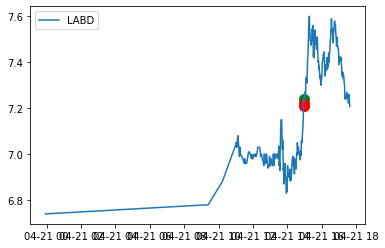

now=2020-04-21 10:18:38.574329
now=2020-04-21 10:18:38.645781
now=2020-04-21 10:29:01.550585
UNIT analysis for run 413 with profit 71.62


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-428.49,-428.49,buy,2020-04-21 14:18:38.574329,5.29,"[4.8, 4.955, 5.18]",[5.4],81,"{'avg': 5.1631, 'rsi': 73.10998952893902, 'macd': [0.022537651665046177, 0.02338366434460326, 0.02338115388733719, 0.02510703710301332, 0.026970825524378128], 'vwap': 5.2813, 'sell_macd': [0.012230587941868265, 0.01283451411162062, 0.0128786836710173, 0.014044547176117916, 0.015290096047935187], 'slow macd': [0.033855481514532215, 0.034036466849479474, 0.03406857456172041, 0.034443466823864455, 0.034893228210468585], 'macd_signal': [0.02212646100164178, 0.022377901670234075, 0.0225785521136547, 0.02308424911152642, 0.023861564394096764], 'resistances': [5.4], 'sell_macd_signal': [0.01170077934210198, 0.011927526296005709, 0.012117757771008026, 0.012503115652030005, 0.013060511731211042]}",5.67,5.17
1,-4025.69,-3597.20,buy,2020-04-21 14:18:38.645781,5.29,"[4.8, 4.955, 5.18]",[5.4],680,"{'avg': 5.1631, 'rsi': 73.10998952893902, 'macd': [0.022537651665046177, 0.02338366434460326, 0.02338115388733719, 0.02510703710301332, 0.026970825524378128], 'vwap': 5.2813, 'sell_macd': [0.012230587941868265, 0.01283451411162062, 0.0128786836710173, 0.014044547176117916, 0.015290096047935187], 'slow macd': [0.033855481514532215, 0.034036466849479474, 0.03406857456172041, 0.034443466823864455, 0.034893228210468585], 'macd_signal': [0.02212646100164178, 0.022377901670234075, 0.0225785521136547, 0.02308424911152642, 0.023861564394096764], 'resistances': [5.4], 'sell_macd_signal': [0.01170077934210198, 0.011927526296005709, 0.012117757771008026, 0.012503115652030005, 0.013060511731211042]}",5.67,5.17
2,38.05,4063.74,sell,2020-04-21 14:22:55.697064,5.34,None,None,761,"{'avg': 5.1742, 'rsi': 79.15069730038424, 'vwap': 5.345, 'reasons': 'rsi max', 'movement': 0.01039697542533076, 'sell_macd': [0.014251135008974458, 0.014751708190305024, 0.015204730043414827, 0.016918711616702886, 0.019592999704762804], 'sell_macd_signal': [0.012852719523418895, 0.013232517256796122, 0.013626959814119863, 0.014285310174636467, 0.015346848080661734]}",5.67,5.17
3,-1983.61,-2021.66,buy,2020-04-21 14:29:01.550585,5.42,"[4.8, 4.955, 5.18]","[5.52, 5.52, 5.53, 5.55]",373,"{'avg': 5.2218, 'rsi': 70.35397894329463, 'macd': [0.04784447853092466, 0.05614653357109489, 0.056036217336799865, 0.0569066394627864, 0.05772982899781631], 'vwap': 5.42, 'sell_macd': [0.028897921590655073, 0.034229637228302856, 0.03404877100792003, 0.034504605498428376, 0.034925975159883826], 'slow macd': [0.040313869824640136, 0.04268498208801219, 0.04360029172002555, 0.044692545337132294, 0.045784310787597704], 'macd_signal': [0.0331916177649477, 0.03778260092617714, 0.04143332420830169, 0.04452798725919863, 0.04716835560692217], 'resistances': [5.52, 5.52, 5.55], 'sell_macd_signal': [0.019320061142420682, 0.022301976359597117, 0.0246513352892617, 0.026621989331095035, 0.028282786496852792]}",6.18,5.17
4,71.62,2055.23,sell,2020-04-21 14:39:39.446425,5.51,None,None,373,"{'avg': 5.2674, 'rsi': 80.1507177995056, 'vwap': 5.5182, 'reasons': 'rsi max', 'movement': 0.02029520295202958, 'sell_macd': [0.03546402395830395, 0.0357533545470341, 0.035514477674005285, 0.034867112868086636, 0.035728034930122554], 'sell_macd_signal': [0.034955223827606206, 0.035114849971491786, 0.035194775511994486, 0.03512924298321292, 0.035249001372594846]}",6.18,5.17


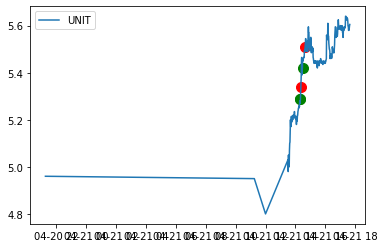

now=2020-04-21 10:56:04.718752
SBOW analysis for run 413 with profit 64.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1772.03,-1772.03,buy,2020-04-21 14:56:04.718752,3.17,"[2.62, 2.63, 2.63, 2.65, 2.8, 2.8001, 2.8484, 3.0536]",[3.25],559,"{'avg': 2.9594, 'rsi': 69.01953444369641, 'macd': [0.04996585164285117, 0.05515199826767159, 0.06417075134104744, 0.06651683136900832, 0.06759690168870369], 'vwap': 3.1956, 'sell_macd': [0.028345440757099993, 0.031716996583582624, 0.037568637531704585, 0.03904305077008896, 0.03968489159519262], 'slow macd': [0.05342821350909199, 0.055022191175003954, 0.05752025348790468, 0.05892687498651794, 0.06012676645727488], 'macd_signal': [0.055685167573979774, 0.055578533712718134, 0.05729697723838399, 0.059140948064508855, 0.060832138789347824], 'resistances': [3.25], 'sell_macd_signal': [0.03230814358177193, 0.032189914182134065, 0.03326565885204817, 0.03442113723565633, 0.03547388810756359]}",3.71,3.03
1,-859.70,912.33,sell,2020-04-21 15:17:29.509588,3.27,None,None,279,"{'avg': 3.0378, 'rsi': 74.66686841090224, 'vwap': 3.2516, 'reasons': 'scale-out', 'movement': 0.02187499999999995, 'sell_macd': [0.02294229612859988, 0.023544752716005757, 0.02422270911247759, 0.024441600991384593, 0.025333703741293956], 'sell_macd_signal': [0.023034134903691803, 0.023136258466154594, 0.023353548595419195, 0.023571159074612276, 0.023923668007948613]}",3.71,3.03
2,-483.50,376.20,sell,2020-04-21 15:19:52.083574,3.30,None,None,114,"{'avg': 3.0426, 'rsi': 78.54695258795357, 'vwap': 3.3015, 'reasons': 'rsi max', 'movement': 0.012232415902140683, 'sell_macd': [0.02422270911247759, 0.024441600991384593, 0.026892145299735937, 0.028384879237415284, 0.029766426731225426], 'sell_macd_signal': [0.023353548595419195, 0.023571159074612276, 0.024235356319637007, 0.025065260903192662, 0.026005494068799213]}",3.71,3.03
3,64.30,547.80,sell,2020-04-21 15:19:52.549911,3.30,None,None,166,"{'avg': 3.0426, 'rsi': 78.54695258795357, 'vwap': 3.3015, 'reasons': 'rsi max', 'movement': 0.012232415902140683, 'sell_macd': [0.02422270911247759, 0.024441600991384593, 0.026892145299735937, 0.028384879237415284, 0.029766426731225426], 'sell_macd_signal': [0.023353548595419195, 0.023571159074612276, 0.024235356319637007, 0.025065260903192662, 0.026005494068799213]}",3.71,3.03


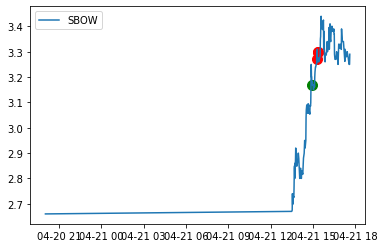

now=2020-04-21 10:06:06.892512
INO analysis for run 413 with profit 17.07


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2861.39,-2861.39,buy,2020-04-21 14:06:06.892512,9.97,"[7.92, 7.95, 8.0, 8.05, 8.06, 8.09, 8.1, 8.14, 8.2, 8.22, 8.22, 8.22, 8.23, 8.23, 8.23, 8.23, 8.28]",None,287,"{'avg': 9.7168, 'rsi': 63.16710044552746, 'macd': [0.08504730414149897, 0.09361151239469123, 0.1101115443606453, 0.11260232103641243, 0.11366942730903418], 'vwap': 9.966, 'sell_macd': [0.047028429421041906, 0.05270652507429929, 0.06351664473821117, 0.06513600233686745, 0.06581165757819818], 'slow macd': [0.0968528457249409, 0.09944165480806788, 0.10384112825110847, 0.10588184151757396, 0.1076699878030869], 'macd_signal': [0.09059643293734083, 0.09119944882881091, 0.0949818679351778, 0.09850595855542472, 0.10153865230614662], 'resistances': [10.0801], 'sell_macd_signal': [0.05042109537365913, 0.050878181313787164, 0.053405873998671964, 0.05575189966631106, 0.057763851248688484]}",10.96,9.64
1,-1405.65,1455.74,sell,2020-04-21 14:07:44.821318,10.18,None,None,143,"{'avg': 9.7367, 'rsi': 71.3647718698444, 'vwap': 10.1699, 'reasons': 'scale-out', 'movement': 0.021063189568706023, 'sell_macd': [0.05270652507429929, 0.06351664473821117, 0.06513600233686745, 0.06841425498079623, 0.07838673424904208], 'sell_macd_signal': [0.050878181313787164, 0.053405873998671964, 0.05575189966631106, 0.0582843707292081, 0.0623048434331749]}",10.96,9.64
2,17.07,1422.72,sell,2020-04-21 14:26:05.991649,9.88,None,None,144,"{'avg': 9.9054, 'rsi': 42.74298268397697, 'vwap': 9.8937, 'reasons': 'below cost & macd negative', 'movement': -0.04716073147256979, 'sell_macd': [0.0328463678289701, 0.02438635482445939, 0.013846262160885914, 0.002430004732635993, -0.005557079039151702], 'sell_macd_signal': [0.06337552646263592, 0.05557769213500061, 0.04723140614017767, 0.03827112585866933, 0.029505484879105127]}",10.96,9.64


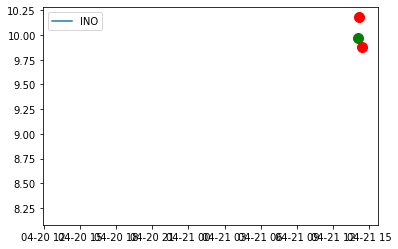

now=2020-04-21 09:52:01.802647
now=2020-04-21 09:52:01.971493
CVM analysis for run 413 with profit 64.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-656.08,-656.08,buy,2020-04-21 13:52:01.802647,11.12,"[10.54, 10.75, 10.84]","[11.58, 11.68]",59,"{'avg': 10.8374, 'rsi': 68.95398708008555, 'macd': [0.0945825129184037, 0.10518300535526137, 0.11029526575046056, 0.11822885704868824, 0.12628817949546267], 'vwap': 11.14, 'sell_macd': [0.058209597642022715, 0.06480312242243613, 0.06780063364844047, 0.07263245234859461, 0.07753214935717523], 'slow macd': [0.03189248097415742, 0.03670977130231101, 0.040683280282667766, 0.045313552590814155, 0.05014082263106978], 'macd_signal': [0.08577658711426865, 0.0896578707624672, 0.09378534976006588, 0.09867405121779035, 0.10419687687332482], 'resistances': [11.505], 'sell_macd_signal': [0.053871586955765355, 0.05605789404909951, 0.0584064419689677, 0.06125164404489308, 0.06450774510734951]}",12.81,10.58
1,-1890.40,-1234.32,buy,2020-04-21 13:52:01.971493,11.12,"[10.54, 10.75, 10.84]","[11.58, 11.68]",111,"{'avg': 10.8374, 'rsi': 68.95398708008555, 'macd': [0.0945825129184037, 0.10518300535526137, 0.11029526575046056, 0.11822885704868824, 0.12628817949546267], 'vwap': 11.14, 'sell_macd': [0.058209597642022715, 0.06480312242243613, 0.06780063364844047, 0.07263245234859461, 0.07753214935717523], 'slow macd': [0.03189248097415742, 0.03670977130231101, 0.040683280282667766, 0.045313552590814155, 0.05014082263106978], 'macd_signal': [0.08577658711426865, 0.0896578707624672, 0.09378534976006588, 0.09867405121779035, 0.10419687687332482], 'resistances': [11.505], 'sell_macd_signal': [0.053871586955765355, 0.05605789404909951, 0.0584064419689677, 0.06125164404489308, 0.06450774510734951]}",12.81,10.58
2,64.60,1955.00,sell,2020-04-21 14:04:40.955963,11.50,None,None,170,"{'avg': 11.0388, 'rsi': 78.14971769691529, 'vwap': 11.5, 'reasons': 'rsi max', 'movement': 0.008771929824561372, 'sell_macd': [0.08850189806940811, 0.09100490911441561, 0.09181498383631137, 0.09385640590744693, 0.09786457367836476], 'sell_macd_signal': [0.08020929155764586, 0.0823684150689998, 0.08425772882246212, 0.08617746423945907, 0.0885148861272402]}",12.81,10.58


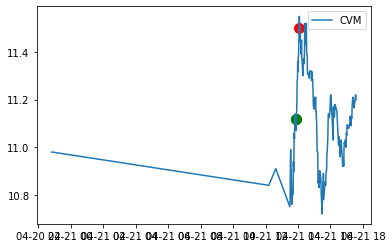

now=2020-04-21 09:51:43.913748
KRMD analysis for run 413 with profit 43.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1883.25,-1883.25,buy,2020-04-21 13:51:43.913748,12.15,"[11.4, 11.7]","[12.16, 12.16]",155,"{'avg': 11.7264, 'rsi': 70.8313494293063, 'macd': [0.12005019066037548, 0.12379390554031744, 0.1253162587306953, 0.13146264645841832, 0.148149843151554], 'vwap': 12.1676, 'sell_macd': [0.0733610609984705, 0.07545239905992673, 0.07610211184729643, 0.07977588659268342, 0.09030901124373081], 'slow macd': [0.057171930997318654, 0.060914639432285256, 0.0642606264579264, 0.0685157538630321, 0.07500155360061633], 'macd_signal': [0.10881449668236073, 0.11181037845395207, 0.11451155450930071, 0.11790177289912424, 0.12395138694961019], 'resistances': [12.385, 12.3996], 'sell_macd_signal': [0.06750031279731417, 0.06909073004983668, 0.07049300640932862, 0.07234958244599958, 0.07594146820554583]}",13.99,11.56
1,-926.14,957.11,sell,2020-04-21 13:54:32.559288,12.43,None,None,77,"{'avg': 11.8645, 'rsi': 74.98094607625431, 'vwap': 12.3781, 'reasons': 'scale-out', 'movement': 0.021565468950327057, 'sell_macd': [0.07977588659268342, 0.08835576449048332, 0.10791988019668608, 0.11916568619896317, 0.1305368897565966], 'sell_macd_signal': [0.07234958244599958, 0.07555081885489633, 0.08202463112325428, 0.08945284213839606, 0.09766965166203617]}",13.99,11.56
2,43.40,969.54,sell,2020-04-21 13:55:05.843508,12.43,None,None,78,"{'avg': 11.9051, 'rsi': 78.21866962893994, 'vwap': 12.5592, 'reasons': 'rsi max', 'movement': 0.01366854384553501, 'sell_macd': [0.08835576449048332, 0.10791988019668608, 0.11916568619896317, 0.1341732533929605, 0.14931456220135964], 'sell_macd_signal': [0.07555081885489633, 0.08202463112325428, 0.08945284213839606, 0.09839692438930894, 0.10858045195171909]}",13.99,11.56


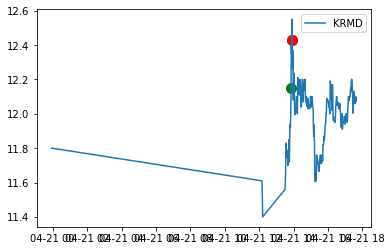

now=2020-04-21 10:12:34.755285
APDN analysis for run 413 with profit 33.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1515.36,-1515.36,buy,2020-04-21 14:12:34.755285,6.56,"[6.1, 6.1824]","[6.75, 6.75, 6.8, 6.8, 6.85]",231,"{'avg': 6.4119, 'rsi': 69.87703728105052, 'macd': [0.03096855798941167, 0.029616688867847074, 0.03579836760316901, 0.04979827695302941, 0.06818455035302762], 'vwap': 6.5518, 'sell_macd': [0.012513730415851576, 0.011995297165221963, 0.01637060505868959, 0.025795902052837327, 0.03800527760603245], 'slow macd': [0.10072633418805932, 0.09924811275044831, 0.09924876049977094, 0.10100825487369836, 0.10406645700680972], 'macd_signal': [0.04655711290908485, 0.043169028100837295, 0.04169489600130364, 0.04331557219164879, 0.04828936782392455], 'resistances': [6.75, 6.75, 6.8, 6.8, 6.85], 'sell_macd_signal': [0.021326784267234538, 0.019460486846832024, 0.01884251048920354, 0.020233188801930296, 0.023787606562750727]}",7.8,6.16
1,-724.16,791.20,sell,2020-04-21 14:32:04.832711,6.88,None,None,115,"{'avg': 6.4992, 'rsi': 69.4659719198261, 'vwap': 6.842, 'reasons': 'scale-out', 'movement': 0.02384500745156485, 'sell_macd': [0.06304440223154906, 0.059997028198937485, 0.05756015196315012, 0.05647738928639168, 0.06216773798909436], 'sell_macd_signal': [0.06334050687509263, 0.0626718111398616, 0.061649479304519306, 0.06061506130089378, 0.0609255966385339]}",7.8,6.16
2,33.32,757.48,sell,2020-04-21 14:44:05.693561,6.53,None,None,116,"{'avg': 6.534, 'rsi': 42.12743250142867, 'vwap': 6.5324, 'reasons': 'below cost & macd negative', 'movement': -0.048791848617176184, 'sell_macd': [0.017944153756266346, 0.014657067601783424, 0.009827428161902851, 0.0017857944663877134, -0.004259449899811862], 'sell_macd_signal': [0.03956908071824279, 0.03458667809495092, 0.029634828108341303, 0.024065021379950584, 0.018400127123998095]}",7.8,6.16


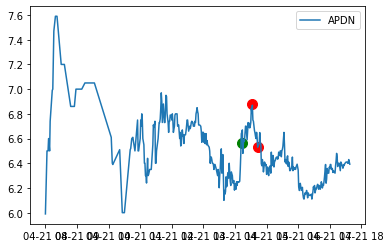

now=2020-04-21 10:07:57.924038
VXRT analysis for run 413 with profit -60.04


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1052.28,-1052.28,buy,2020-04-21 14:07:57.924038,3.33,"[2.751, 3.075]",[3.39],316,"{'avg': 3.09, 'rsi': 63.995265511304154, 'macd': [0.09398976058196817, 0.10530780032186815, 0.10499791350473142, 0.10595172966219124, 0.10708703600023295], 'vwap': 3.3399, 'sell_macd': [0.05112879299203943, 0.05866954619103604, 0.058588710421539236, 0.05932327072554777, 0.06016418432963855], 'slow macd': [0.11713606952411837, 0.12013256031047792, 0.12109793218499698, 0.12227223404606358, 0.12347694402052589], 'macd_signal': [0.10185545643515119, 0.10254592521249459, 0.10303632287094196, 0.10361940422919182, 0.10431293058340005], 'resistances': [3.39], 'sell_macd_signal': [0.05583074792021801, 0.05639850757438162, 0.05683654814381314, 0.05733389266016007, 0.05789995099405577]}",4.24,3.04
1,-60.04,992.24,sell,2020-04-21 14:25:06.157498,3.14,None,None,316,"{'avg': 3.1259, 'rsi': 40.279895132920764, 'vwap': 3.1345, 'reasons': 'below cost & macd negative', 'movement': -0.08915697674418598, 'sell_macd': [0.02029337898978012, 0.01617237919817427, 0.013790140669673878, 0.006040472456950496, -0.0004247296887682772], 'sell_macd_signal': [0.031471353210179194, 0.02841155840777821, 0.025487274860157345, 0.021597914379515977, 0.017193385565859125]}",4.24,3.04


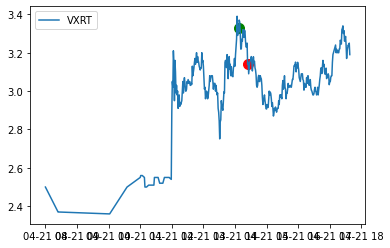

now=2020-04-21 10:44:11.666764
FNGD analysis for run 413 with profit 5.94


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3035.34,-3035.34,buy,2020-04-21 14:44:11.666764,5.11,"[4.9004, 4.96]","[5.5, 5.65]",594,"{'avg': 4.9522, 'rsi': 76.35428091481982, 'macd': [0.029123218490024527, 0.029539375601402185, 0.031124235154745605, 0.03280896289420543, 0.03535045656022984], 'vwap': 5.1097, 'sell_macd': [0.017023996091547033, 0.017274472529487994, 0.018284266214513067, 0.019353140953305648, 0.02097365190621847], 'slow macd': [0.03715313369671236, 0.037341683824487326, 0.03777530521941408, 0.038273770476850544, 0.038991032962037764], 'macd_signal': [0.02629041410951581, 0.026940206407893085, 0.027777012157263588, 0.028783402304651956, 0.03009681315576753], 'resistances': [5.5, 5.65], 'sell_macd_signal': [0.015194024510048535, 0.015610114113936428, 0.016144944534051756, 0.016786583817902535, 0.01762399743556572]}",5.59,4.95
1,5.94,3041.28,sell,2020-04-21 14:48:05.635425,5.12,None,None,594,"{'avg': 4.9587, 'rsi': 78.98053360257316, 'vwap': 5.13, 'reasons': 'rsi max', 'movement': 0.0039138943248531455, 'sell_macd': [0.020454171386737663, 0.02094777729088282, 0.02115905751111402, 0.02208785953322767, 0.023044226569508552], 'sell_macd_signal': [0.01752010133166956, 0.01820563652351221, 0.018796320721032572, 0.01945462848347159, 0.020172548100678984]}",5.59,4.95


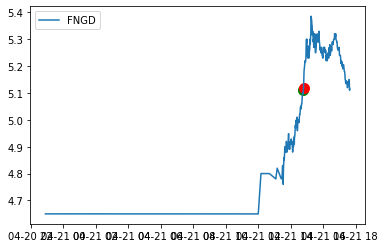

now=2020-04-21 10:48:39.195937
SQQQ analysis for run 413 with profit 16.94


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3421.88,-3421.88,buy,2020-04-21 14:48:39.195937,14.14,[13.77],[14.18],242,"{'avg': 13.712, 'rsi': 73.75373615372759, 'macd': [0.06803769436955598, 0.0664070006161559, 0.06636691860860644, 0.07115526554162521, 0.0751090386026334], 'vwap': 14.1452, 'sell_macd': [0.0397682782162736, 0.03865023024564351, 0.038575774291313536, 0.041647941414026945, 0.04416069577699844], 'slow macd': [0.09165356976893158, 0.09142624340861616, 0.09147071244951199, 0.09248328358637714, 0.09347008608601115], 'macd_signal': [0.06412853634218085, 0.06458422919697586, 0.06494076707930198, 0.06618366677176662, 0.06796874113793998], 'resistances': [14.29, 14.3625], 'sell_macd_signal': [0.03735288458285929, 0.03761235371541614, 0.03780503783059562, 0.038573618547281883, 0.0396910339932252]}",15.32,13.75
1,16.94,3438.82,sell,2020-04-21 14:49:46.834895,14.21,None,None,242,"{'avg': 13.7218, 'rsi': 78.26904085343406, 'vwap': 14.2117, 'reasons': 'rsi max', 'movement': 0.00547282677866876, 'sell_macd': [0.03865023024564351, 0.038575774291313536, 0.041647941414026945, 0.04347498149128448, 0.04904053244120732], 'sell_macd_signal': [0.03761235371541614, 0.03780503783059562, 0.038573618547281883, 0.0395538911360824, 0.041451219397107386]}",15.32,13.75


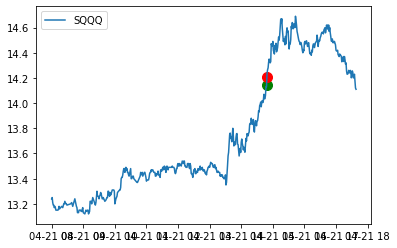

now=2020-04-21 10:20:20.132624
PAVM analysis for run 413 with profit -54.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1067.00,-1067.00,buy,2020-04-21 14:20:20.132624,2.75,"[2.245, 2.26, 2.28, 2.3581, 2.46]",None,388,"{'avg': 2.5392, 'rsi': 66.70770506918444, 'macd': [0.025641542153719055, 0.030650337730586674, 0.04188343582949372, 0.04658533962972555, 0.050089277483129635], 'vwap': 2.7476, 'sell_macd': [0.013993441714983401, 0.017297364504227364, 0.024634221684102897, 0.02767288673745938, 0.029909860977250347], 'slow macd': [0.034311260905092844, 0.0354469773170325, 0.037970566103359804, 0.03950551033883576, 0.040924896442184444], 'macd_signal': [0.028355431919104983, 0.02881441308140132, 0.0314282176310198, 0.03445964203076095, 0.03758556912123469], 'resistances': [2.796], 'sell_macd_signal': [0.015657029411974117, 0.015985096430424766, 0.01771492148116039, 0.01970651453242019, 0.02174718382138622]}",3.49,2.51
1,-54.32,1012.68,sell,2020-04-21 14:40:06.563326,2.61,None,None,388,"{'avg': 2.5773, 'rsi': 39.65605364169005, 'vwap': 2.62, 'reasons': 'below cost & macd negative', 'movement': -0.0708231372131787, 'sell_macd': [0.016205307545714476, 0.013884475854450962, 0.012410003421590599, 0.003837557325574892, -0.0018583429742502489], 'sell_macd_signal': [0.02222012046109317, 0.02055299153976473, 0.018924393916129902, 0.0159070265980189, 0.01235395268356507]}",3.49,2.51


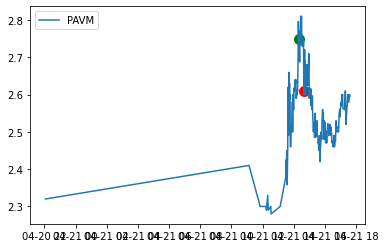

In [13]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])



In [60]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [61]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

2416

In [62]:
minute_history['NURO'][:index]

,open,high,low,close,volume
timestamp,,,,,
2020-04-06 07:18:00-04:00,1.040,1.040,1.030,1.030,2689.0
2020-04-06 07:31:00-04:00,1.010,1.010,1.010,1.010,200.0
2020-04-06 07:49:00-04:00,1.030,1.030,1.030,1.030,300.0
2020-04-06 09:28:00-04:00,1.060,1.060,1.060,1.060,106.0
2020-04-06 09:30:00-04:00,1.000,1.090,1.000,1.090,9920.0
...,...,...,...,...,...
2020-04-06 12:39:00-04:00,0.990,0.990,0.990,0.990,100.0
2020-04-06 12:40:00-04:00,0.993,0.993,0.993,0.993,1000.0
2020-04-06 12:42:00-04:00,1.000,1.000,0.980,0.980,10461.0


In [68]:
series = minute_history['NURO'][:2417]['close']

In [70]:
MACD(series.dropna().between_time("9:30", "16:00"))

(timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04-06 09:32:00-04:00         NaN
 2020-04-06 09:35:00-04:00         NaN
 2020-04-06 09:38:00-04:00         NaN
 2020-04-06 09:39:00-04:00         NaN
                                ...   
 2020-04-16 13:40:00-04:00    0.190075
 2020-04-16 13:41:00-04:00    0.194543
 2020-04-16 13:42:00-04:00    0.189046
 2020-04-16 13:43:00-04:00    0.188320
 2020-04-16 13:44:00-04:00    0.179718
 Length: 1883, dtype: float64,
 timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04-06 09:32:00-04:00         NaN
 2020-04-06 09:35:00-04:00         NaN
 2020-04-06 09:38:00-04:00         NaN
 2020-04-06 09:39:00-04:00         NaN
                                ...   
 2020-04-16 13:40:00-04:00    0.111862
 2020-04-16 13:41:00-04:00    0.128398
 2020-04-16 13:42:00-04:00    0.140528
 2020-04-16 13:43:00-04:00    0.150086
 2020-04-16 13:44:00-04:00    0.156013
 Length: 1883, dtype: float64,
 timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04